In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr
from scipy.spatial import distance
from scipy import interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
import config
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from calibration import CharucoEstimator
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.predictors.tongue_out import TongueOutAnalyzer, TONGUE_CLASS
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [2]:
orm = ORM()
FIGURE_PATH = '../notebooks/figures'
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -3, 'msi-regev': 0.06}

In [3]:
with orm.session() as s:
    orm_res = s.query(Video, Block, Experiment).join(
      Block, Block.id == Video.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.animal_id == 'PV91',
        Video.cam_name == 'front'
    ).all()

In [4]:
dlc = DLCArenaPose(cam_name='front', orm=orm)
res = {}
days = set()
for vid, _, _ in tqdm(orm_res):
  try:
    pose_df = dlc.load(video_db_id=int(vid.id))
    res[int(vid.id)] = [pose_df.nose.x.values, pose_df.nose.y.values,
                        len(pose_df) * [vid.start_time.strftime('%Y%m%d')]]
    
  except Exception:
    continue

  0%|          | 0/306 [00:00<?, ?it/s]

In [5]:
xf = {'x': [], 'y': [], 'video_id': [], 'day': []}
for vid_id, r in res.items():
  x, y, day = r[0], r[1], r[2]
  xf['x'].extend(x.tolist())
  xf['y'].extend(y.tolist())
  xf['day'].extend(day)
  xf['video_id'].extend([vid_id for _ in range(len(x))])
  
xf = pd.DataFrame(xf)
xf = xf.query('0 <= x < 43 and y >= -2')
xf

x         y  video_id       day
0        42.485432  0.383447       495  20230530
1        42.484500  0.386294       495  20230530
2        42.488717  0.389675       495  20230530
3        42.478963  0.392972       495  20230530
4        42.478083  0.393868       495  20230530
...            ...       ...       ...       ...
3533749  15.110024 -1.807199      1198  20230619
3533750  14.909484 -1.861303      1198  20230619
3533751  14.741387 -1.909137      1198  20230619
3533752  14.620501 -1.931702      1198  20230619
3533753  14.526955 -1.984118      1198  20230619

[2123959 rows x 4 columns]

In [6]:
def get_out_of_experiment_pose(animal, day):
    tracking_dir = Path(config.EXPERIMENTS_DIR) / animal / day / 'tracking' / 'predictions'
    if not tracking_dir.exists():
        print(f'{tracking_dir} not exist')
        return []
    
    pose_ = []
    for p in tracking_dir.rglob('*.csv'):
        df = pd.read_csv(p, index_col=0)
        if df.empty:
            continue
        df = df[~df.x.isna()]
        pose_.append(df[['frame_id', 'x', 'y']])
    return pd.concat(pose_)

xf_ = get_out_of_experiment_pose('PV91', '20230619')

In [7]:
caliber = CharucoEstimator('top', is_debug=False)
cap = cv2.VideoCapture('/data/Pogona_Pursuit/output/experiments/PV91/20230621/tracking/top_20230621T140038.mp4')
ret, frame = cap.read()
caliber.init(frame)
cap.release()

In [50]:
x = xf_[['x', 'y']].apply(lambda pos: caliber.get_location(*pos), axis=1)

<AxesSubplot:xlabel='x', ylabel='y'>

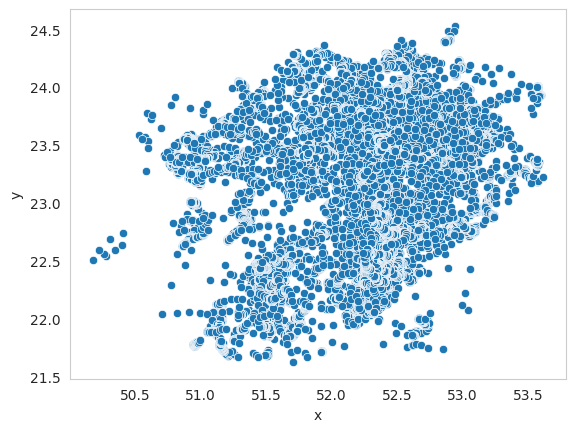

In [59]:
xf_ = pd.DataFrame(x.tolist(), columns=('x', 'y'))
sns.scatterplot(data=xf_, x='x', y='y')

In [9]:
days_res = {}
orig_days = {}
for day in tqdm(xf.day.unique()):
    xf_ = get_out_of_experiment_pose('PV91', day)
    if isinstance(xf_, pd.DataFrame):
        orig_days[day] = xf_
        zf_ = xf_[['x', 'y']].apply(
                lambda pos: caliber.get_location(*pos), axis=1)
        zf_ = pd.DataFrame(zf_.tolist(), columns=('x', 'y'))
        days_res[day] = zf_

  0%|          | 0/41 [00:00<?, ?it/s]

/data/Pogona_Pursuit/output/experiments/PV91/20230530/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230531/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230513/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230514/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230603/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230515/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230516/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230518/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230517/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230522/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230521/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230519/tracking/pr

<AxesSubplot:xlabel='x', ylabel='y'>

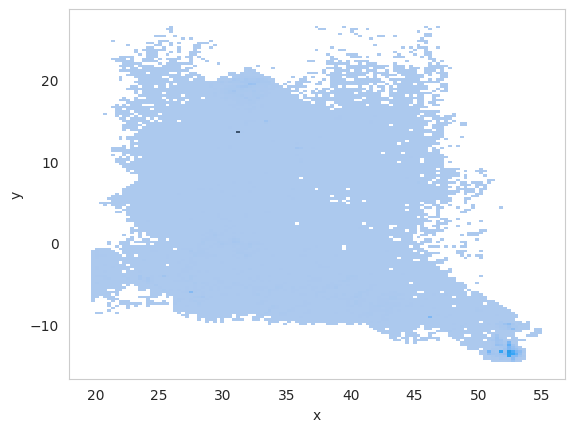

In [18]:
day_df = pd.concat(list(days_res.values()))
sns.histplot(data=day_df, x='x', y='y')

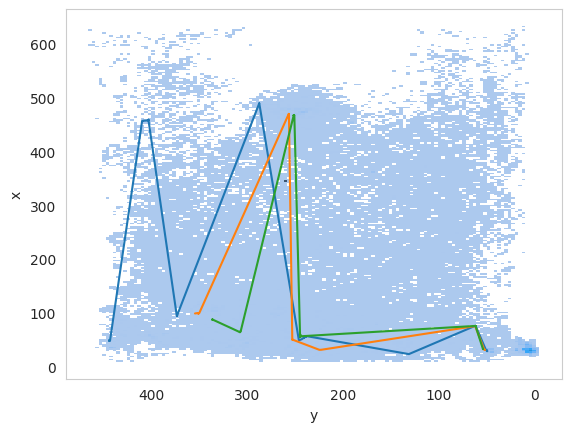

In [41]:
day_df = pd.concat(list(orig_days.values()))
sns.histplot(data=day_df, x='y', y='x')
xf_ = orig_days['20230611']
c = 0
for group_id, idx in xf_.groupby(xf_.frame_id.diff().ne(1).cumsum()).groups.items():
    if c >= 3:
        break
    if len(idx) > 50:
        sns.lineplot(data=xf_.loc[idx].sort_values(by='frame_id'), x='y', y='x')
        c += 1
plt.gca().invert_xaxis()

In [4]:
cap = cv2.VideoCapture((p.parent.parent / p.with_suffix('.mp4').name).as_posix())
ret, frame = cap.read()
h, w = frame.shape[:2]
cap.release

<function VideoCapture.release>

In [7]:
res = {}
for p in Path(config.EXPERIMENTS_DIR).rglob('*/predictions_gd/*.csv'):
    rf = pd.read_csv(p, index_col=0)
    rf['vid_name'] = p.stem
    res[p.stem] = rf
    
rdf = pd.concat(res.values())
rdf['x'] = rdf.cam_x * w
rdf['y'] = rdf.cam_y * h

(-70.37516498565675,
 1477.8784646987917,
 22.629645107223823,
 1027.8108175482998)

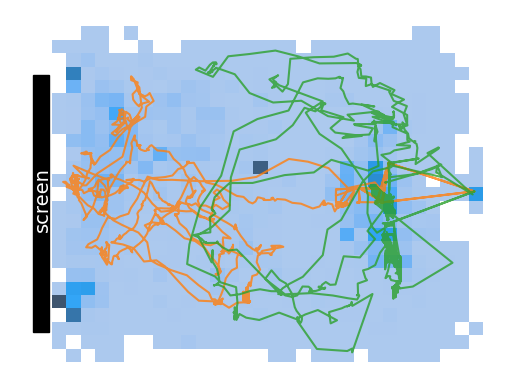

In [29]:
from matplotlib.patches import Rectangle

example_vids = [('top_20230625T093053', 'tab:orange'), ('top_20230624T090108', 'tab:green')]
ax = plt.subplot()
sns.histplot(data=rdf, x='x', y='y', bins=(30, 25), ax=ax)
for vid_name, color in example_vids:
    rf = rdf.query(f'vid_name=="{vid_name}"').sort_values(by='frame_id')
    ax.plot(rf.x, rf.y, color=color, alpha=0.8)
ax.add_patch(Rectangle((0, 150), 50, 700, color='k'))
ax.text(0, (150+700)//2, 'screen', rotation=90, color='w', va='bottom', fontsize=14)
plt.axis('off')

In [96]:
rdf.query(f'vid_name=="{example_vid}"')

frame_id     logit     cam_x     cam_y        dx        dy  \
0             0  0.394179  0.758851  0.465268  0.083925  0.149219   
1             1  0.391437  0.758769  0.465301  0.083692  0.149118   
2             2  0.386831  0.758689  0.465289  0.083616  0.149186   
3             3  0.378504  0.758812  0.465243  0.083695  0.149050   
4             4  0.380073  0.758867  0.465129  0.084108  0.149075   
...         ...       ...       ...       ...       ...       ...   
17997     17997  0.549806  0.703380  0.465802  0.357111  0.325024   
17998     17998  0.554601  0.703281  0.465765  0.356949  0.324955   
17999     17999  0.547358  0.703376  0.465783  0.357087  0.324984   
18000     18000  0.584231  0.703730  0.464642  0.358077  0.323556   
18001     18001  0.585798  0.703543  0.464612  0.357695  0.323465   

                  vid_name            x           y  
0      top_20230625T093053  1092.745512  502.489040  
1      top_20230625T093053  1092.627648  502.524832  
2      top_20230625T093053  1092.512650  502.512466  
3      top_20230625T093053  1092.689381  502.462008  
4      top_20230625T093053  1092.768854  502.339374  
...                    ...          ...         ...  
17997  top_20230625T093053  1012.867445  503.065793  
17998  top_20230625T093053  1012.725130  503.026006  
17999  top_20230625T093053  1012.861872  503.045348  
18000  top_20230625T093053  1013.370480  501.813608  
18001  top_20230625T093053  1013.102352  501.780906  

[18002 rows x 9 columns]

/tmp/ipykernel_249199/1814092923.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


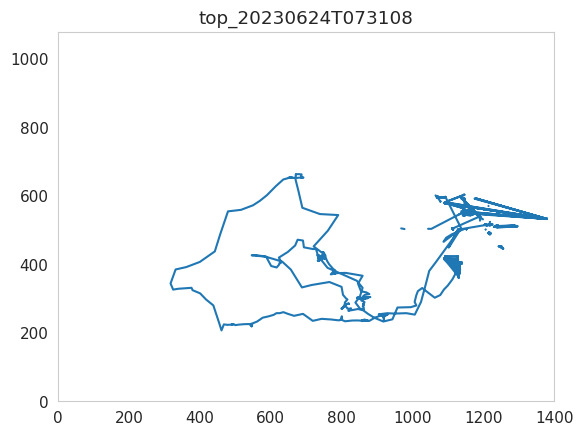

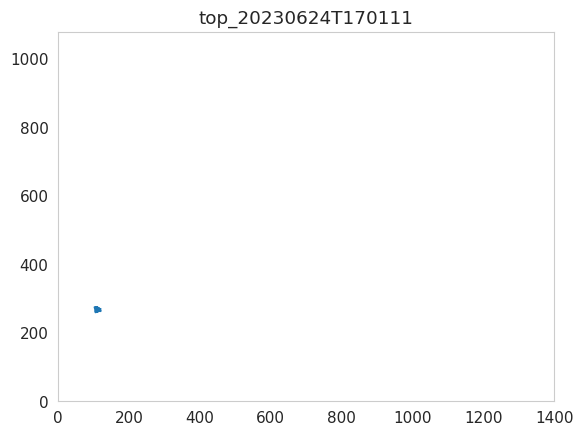

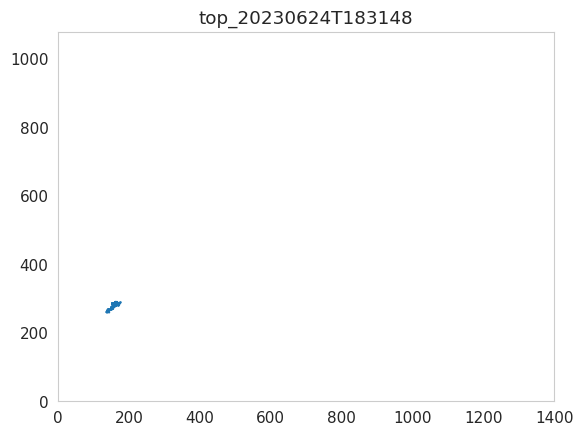

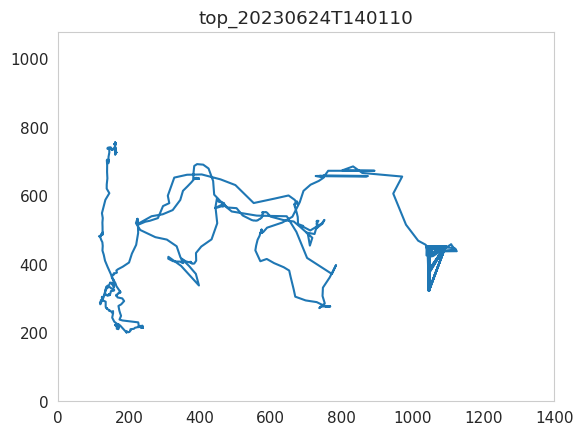

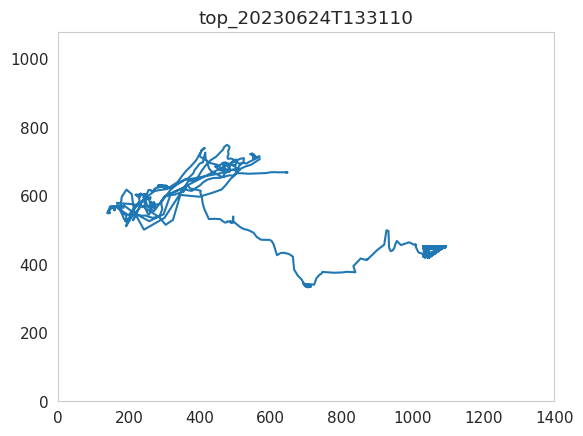

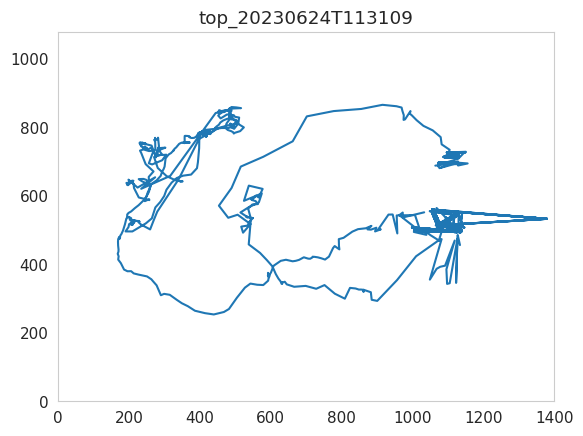

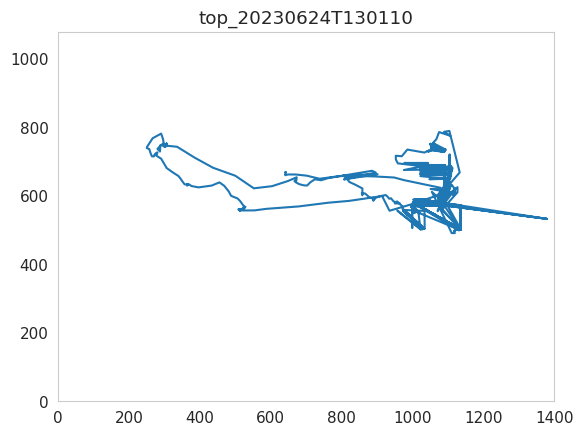

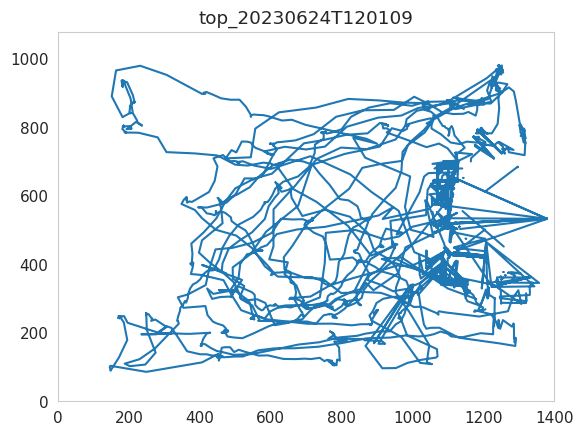

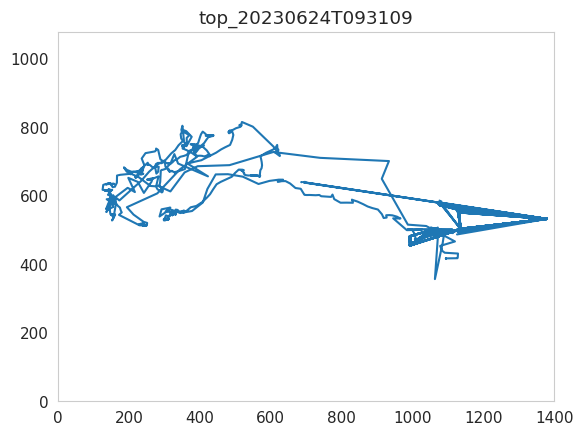

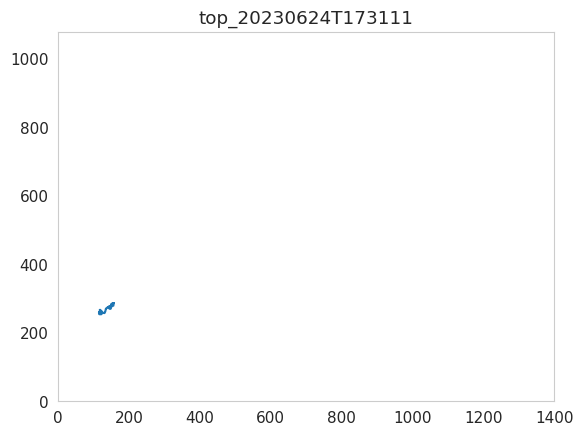

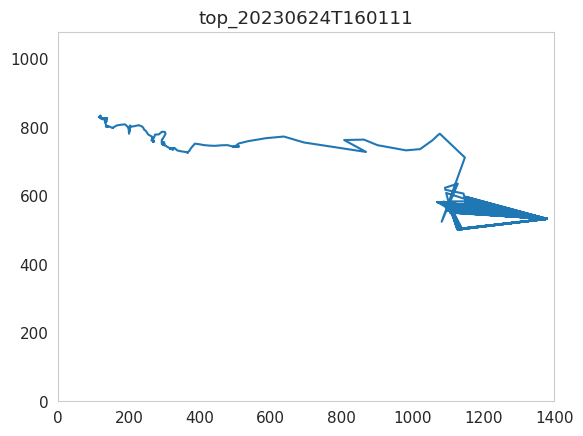

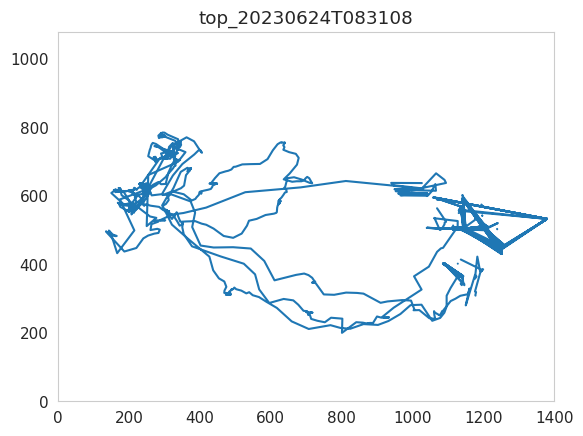

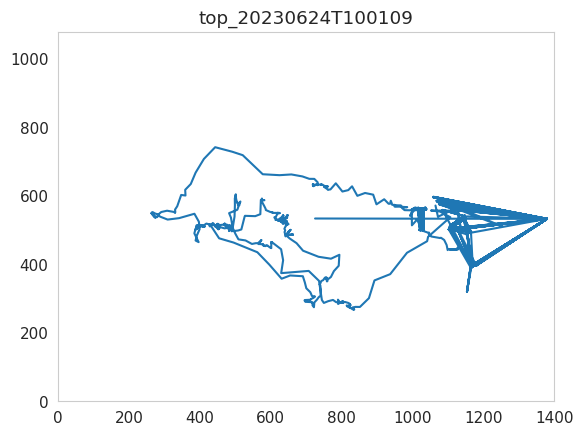

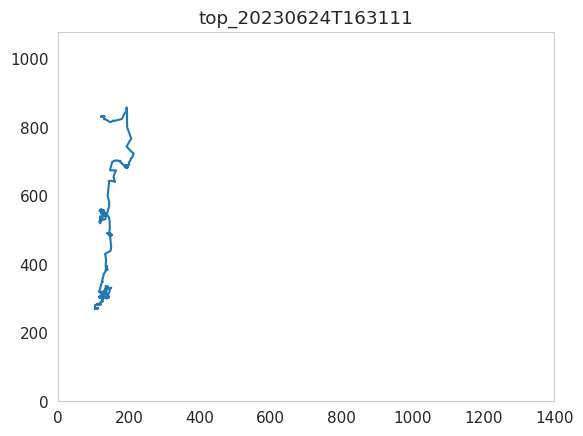

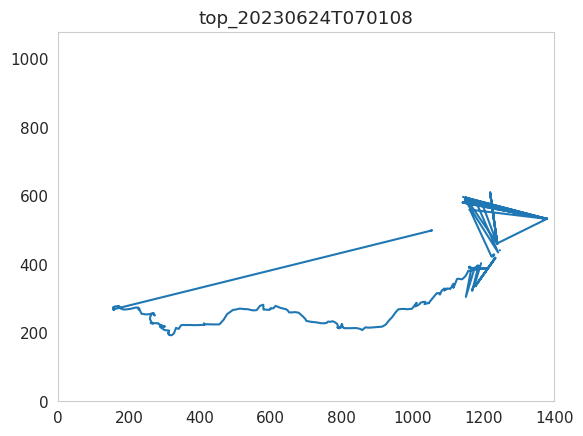

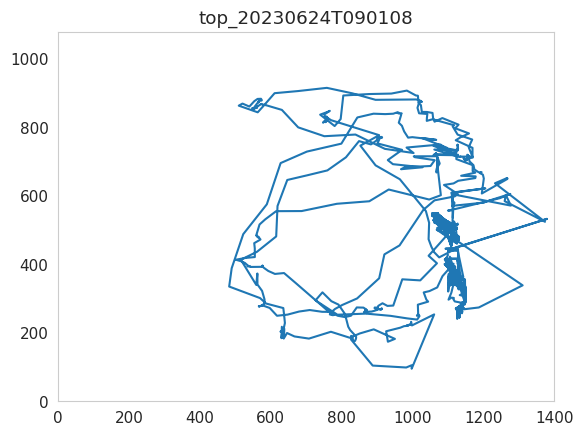

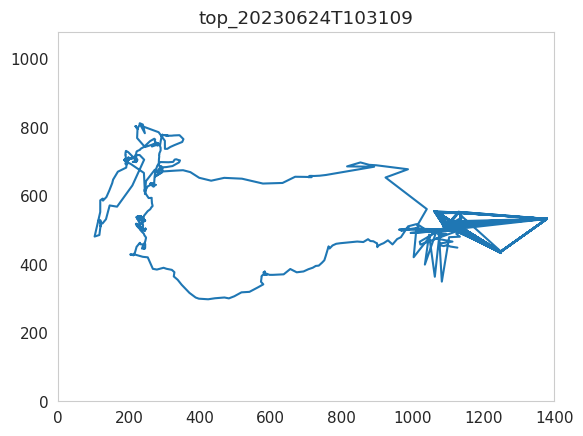

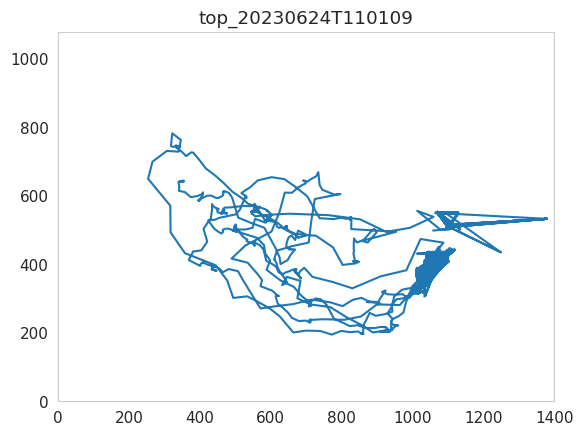

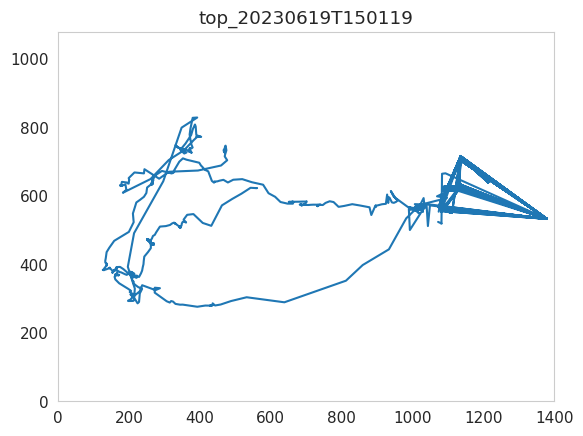

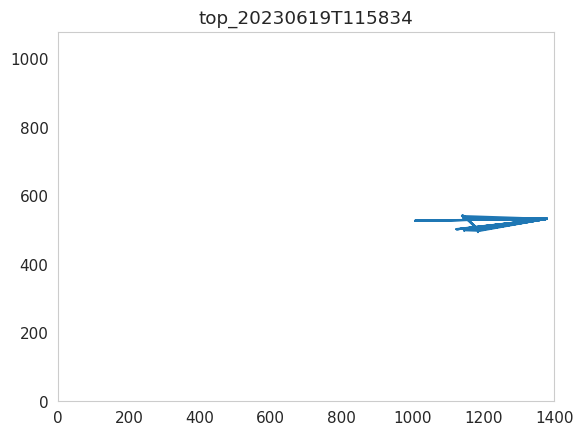

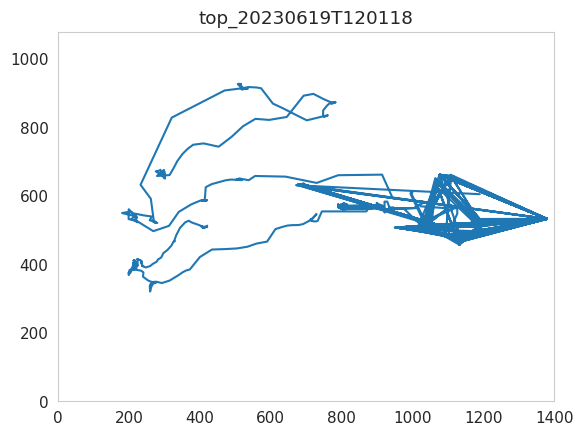

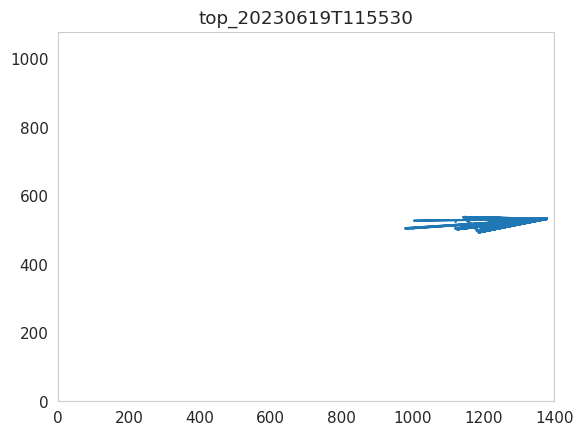

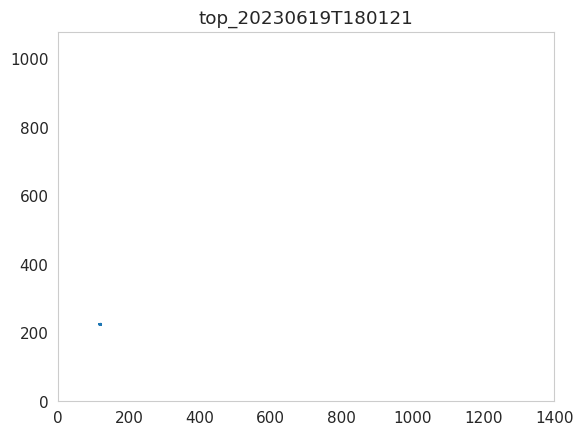

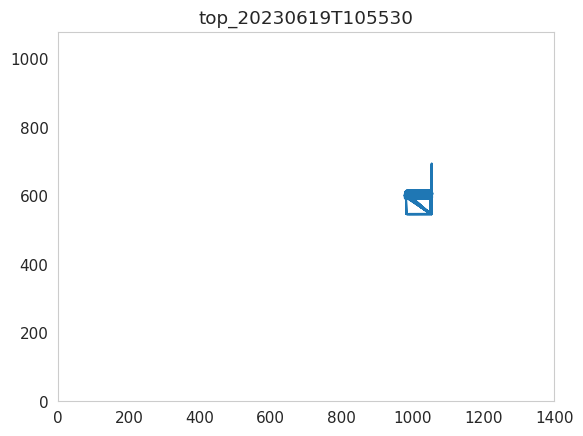

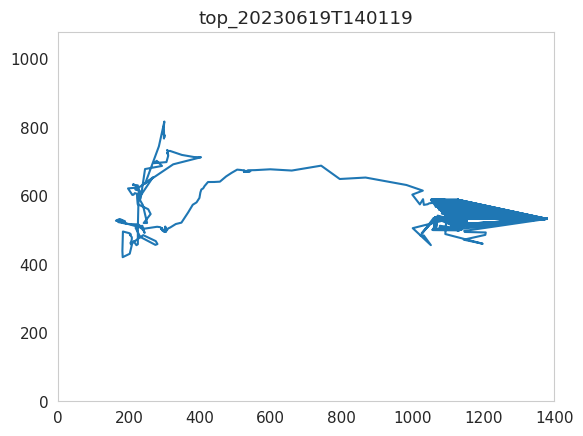

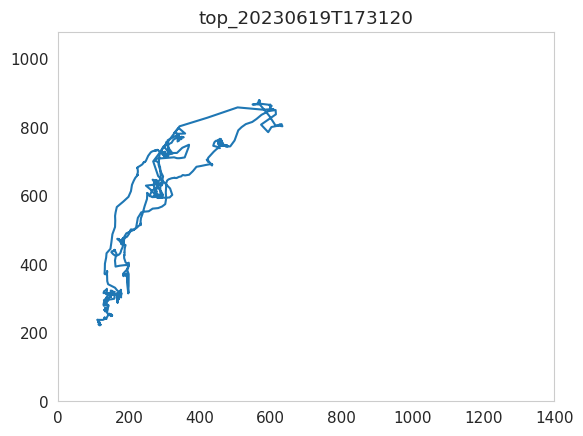

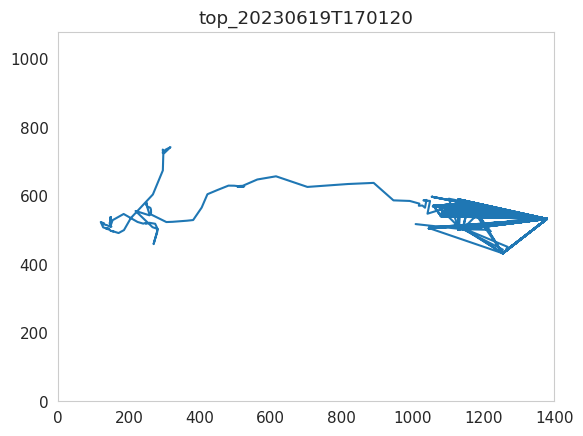

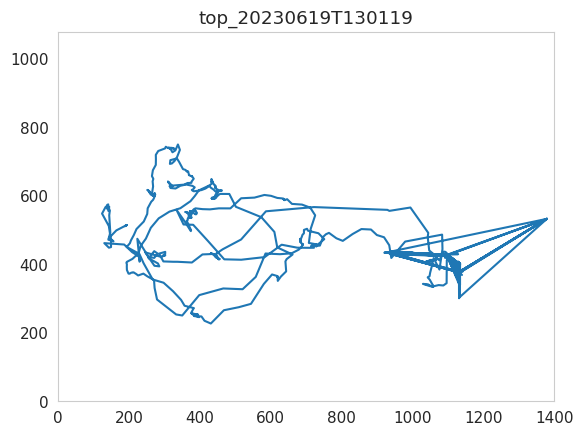

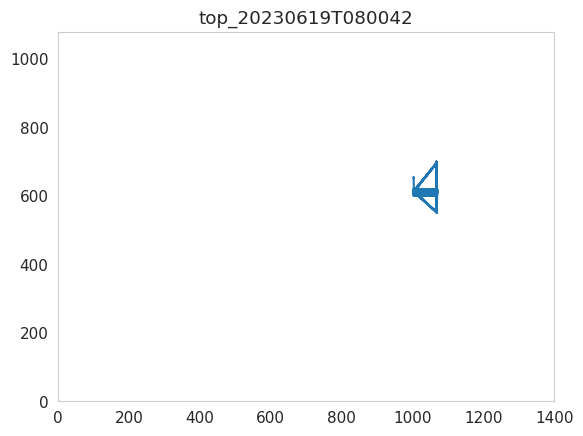

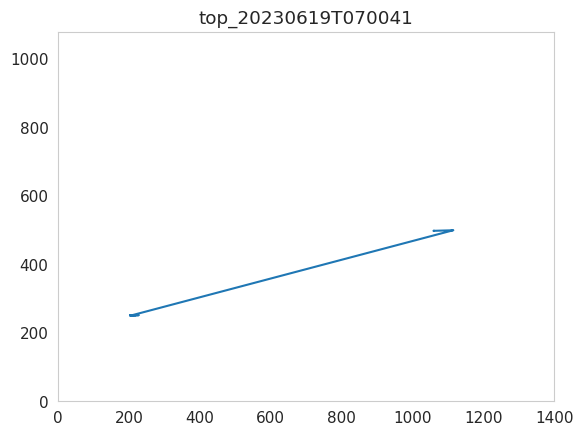

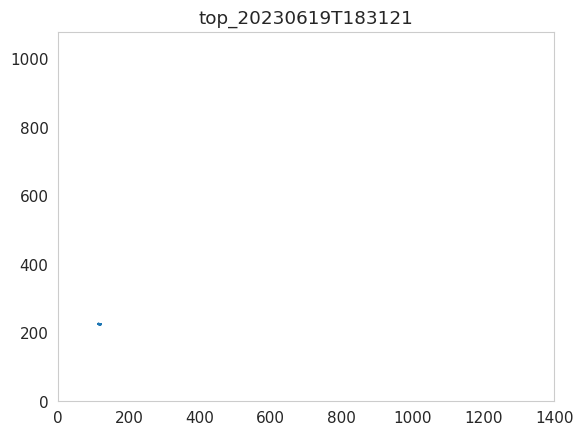

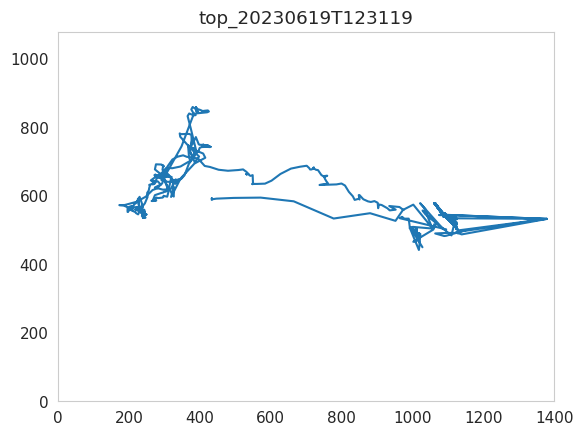

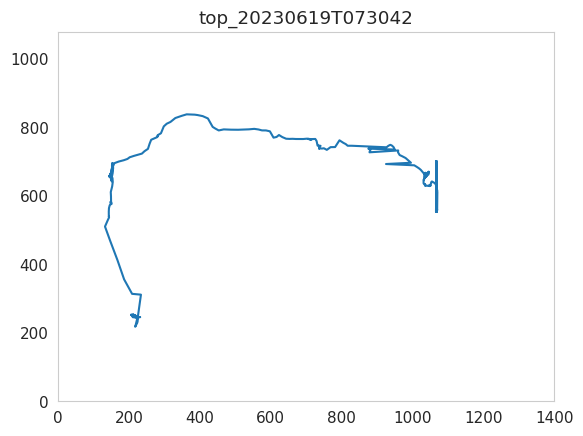

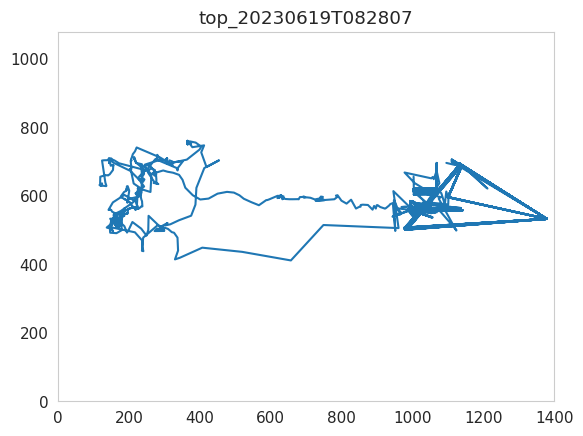

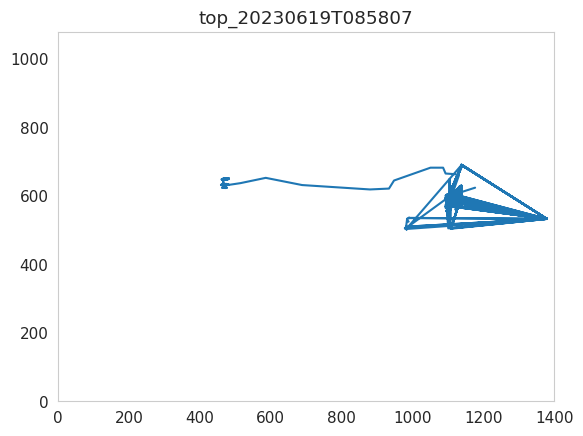

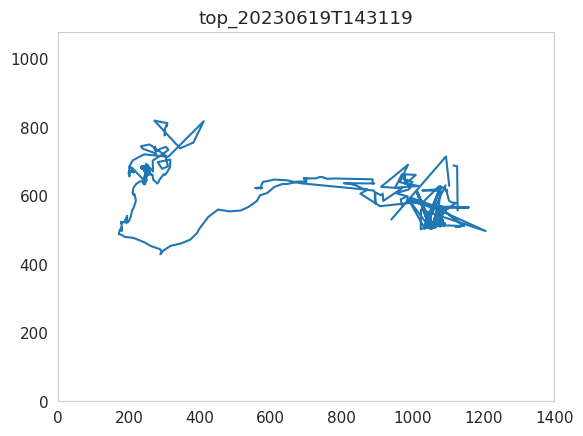

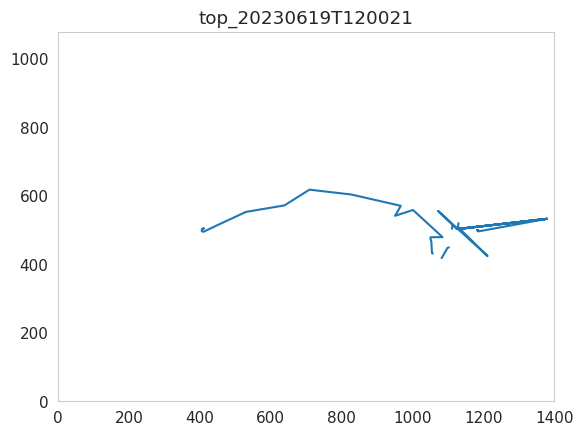

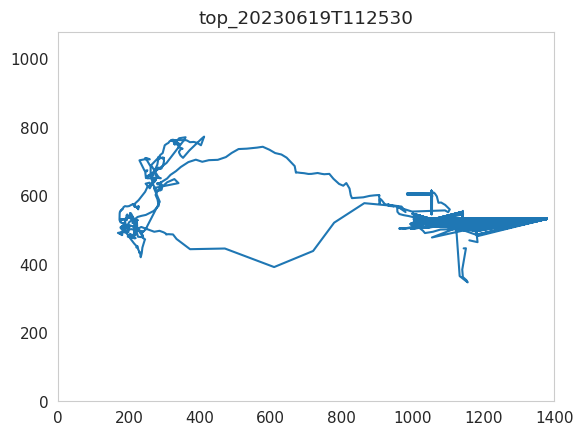

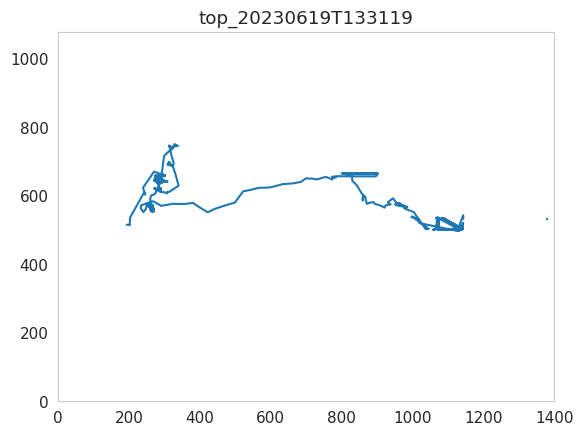

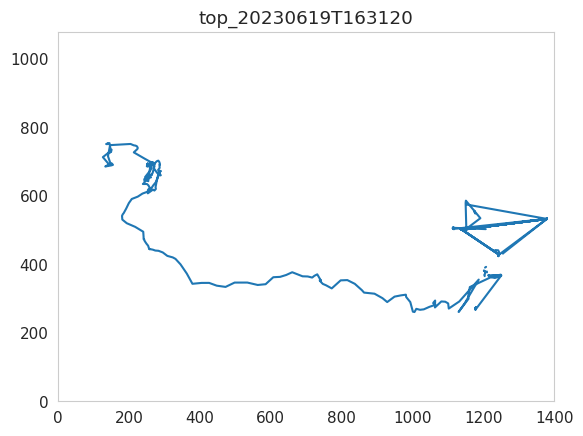

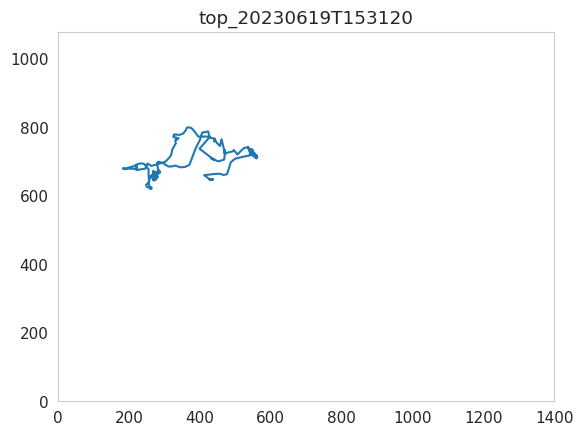

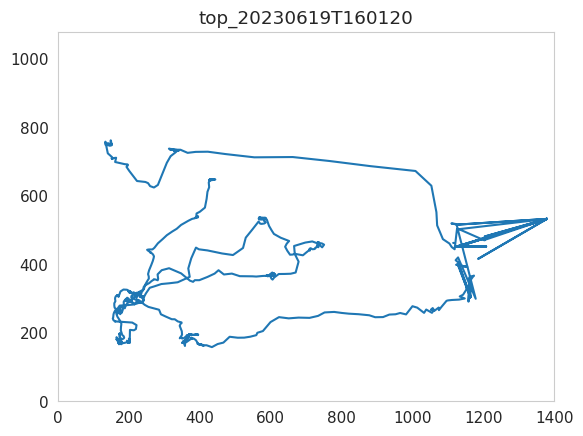

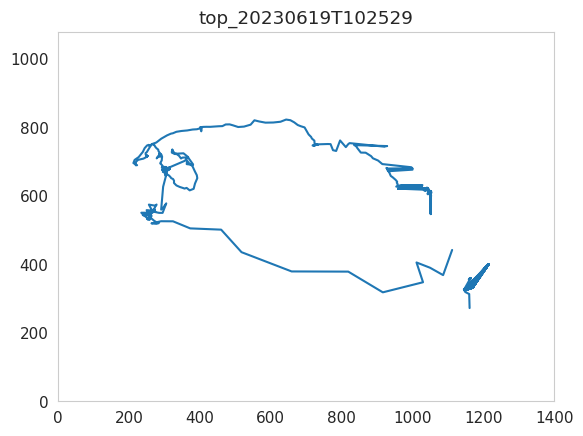

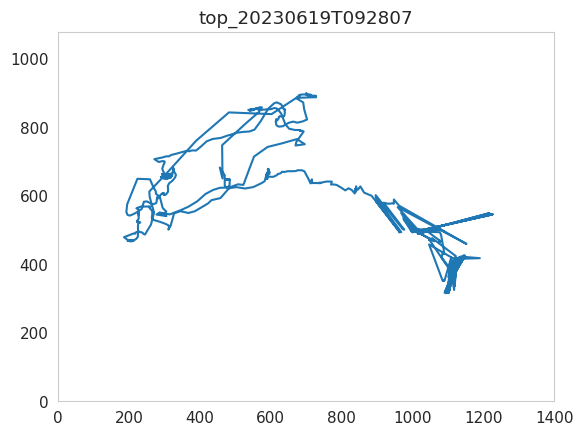

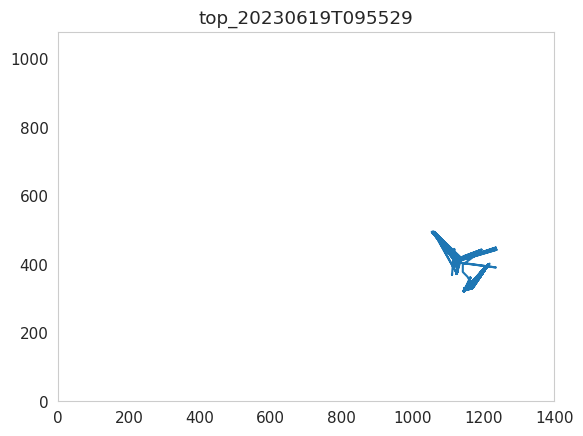

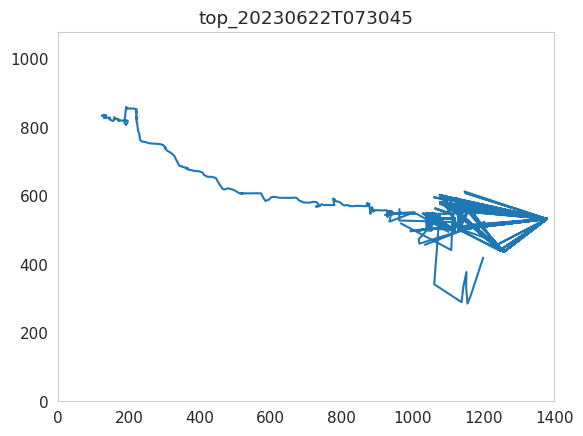

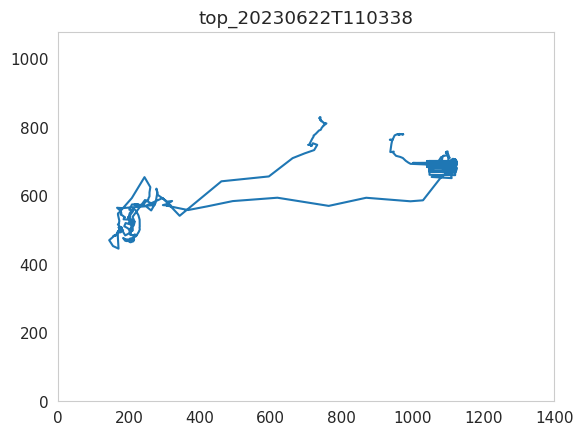

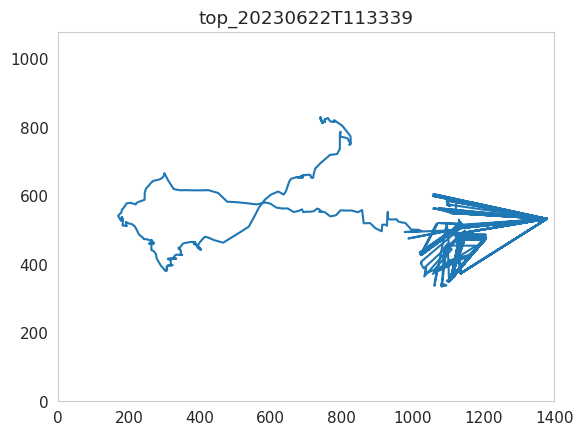

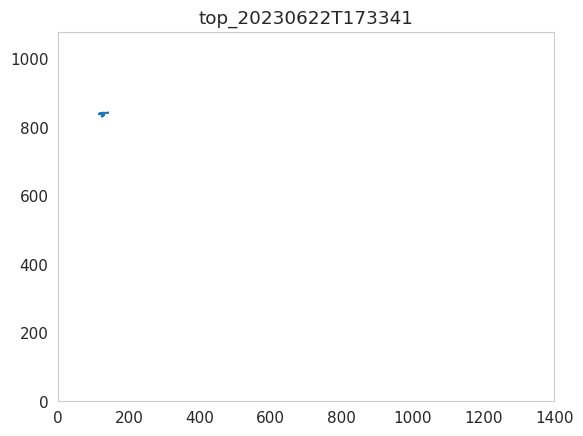

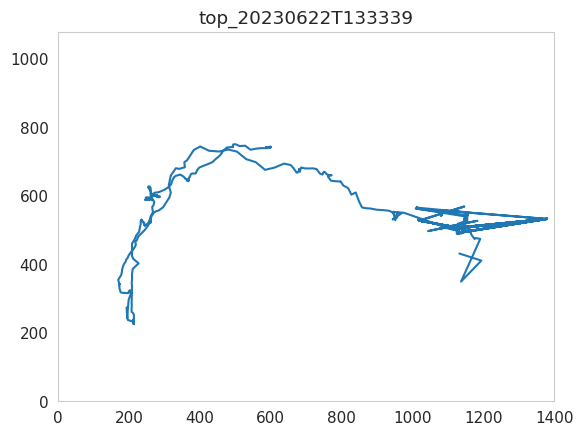

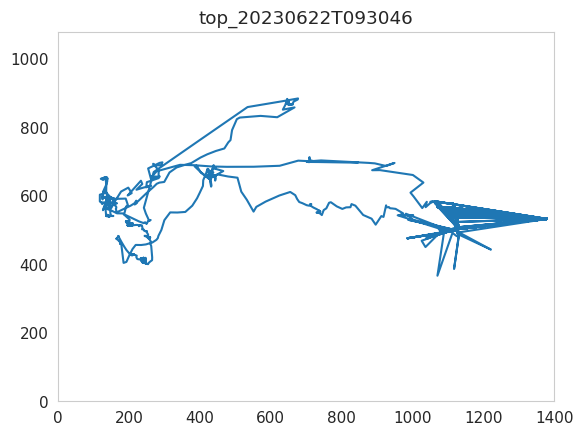

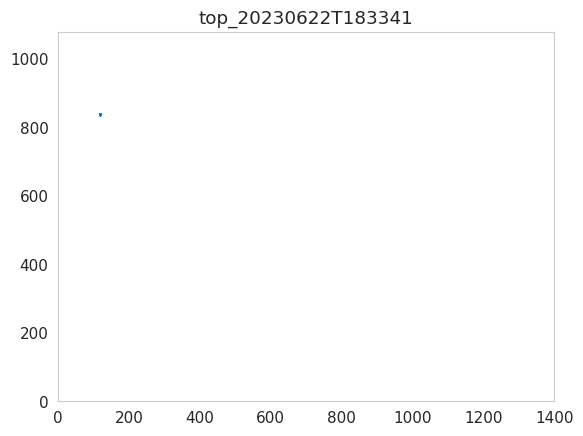

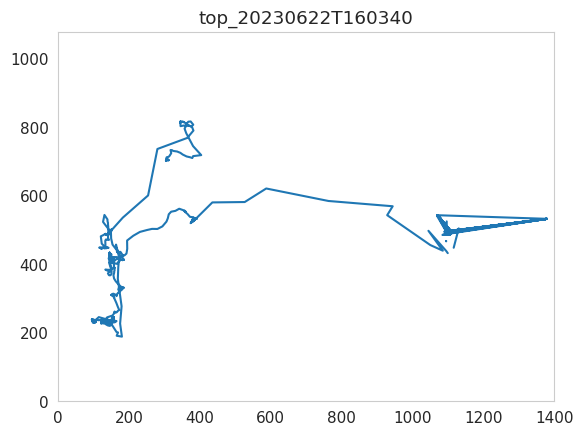

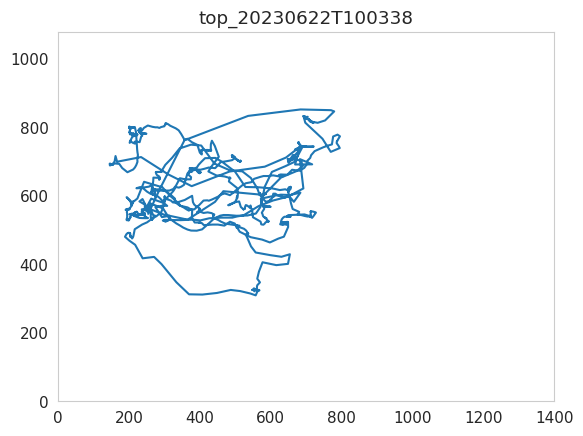

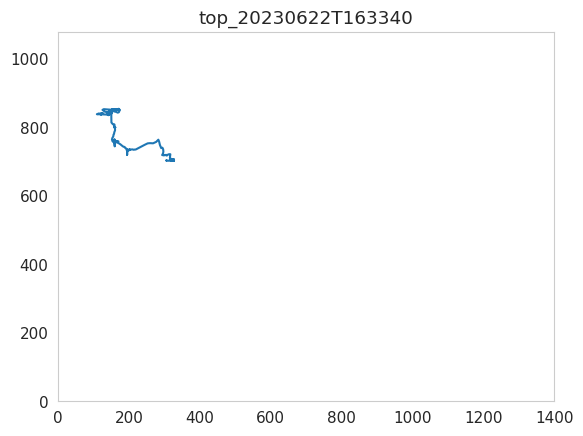

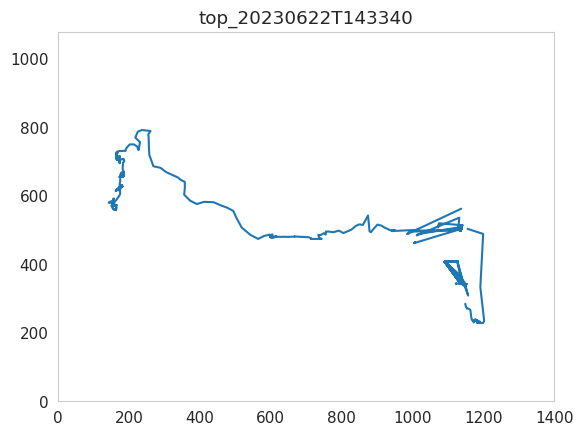

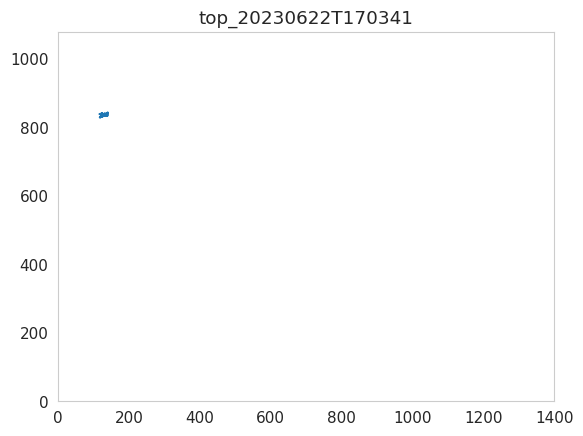

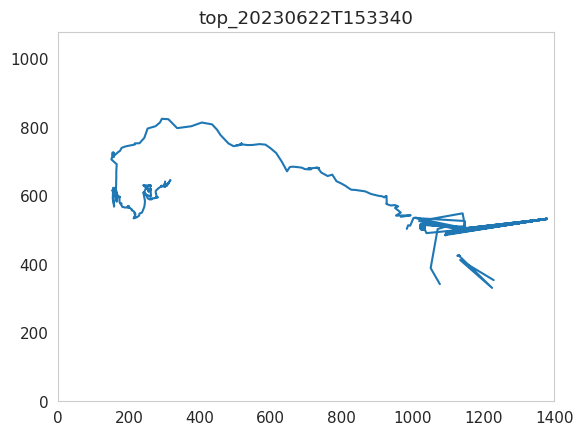

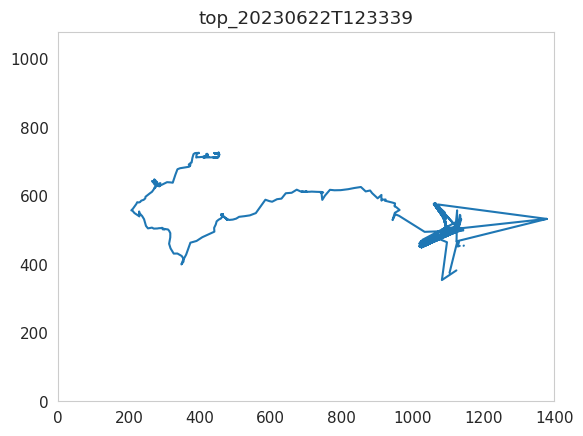

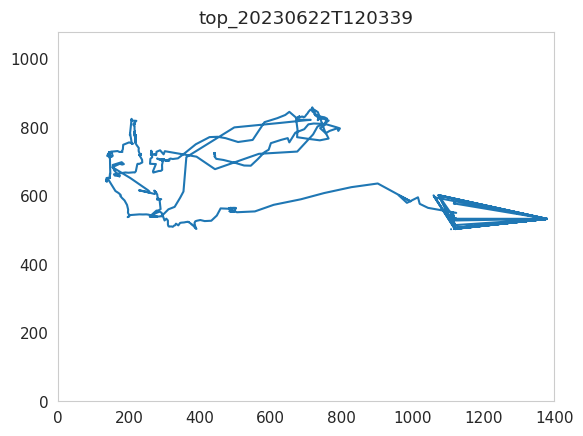

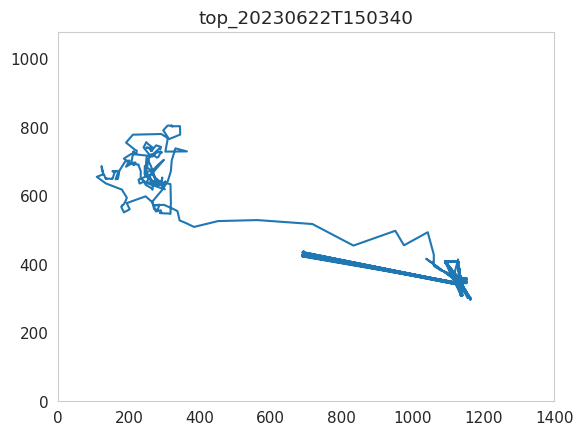

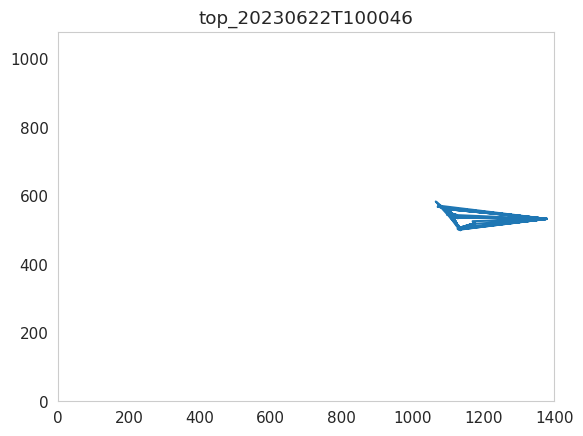

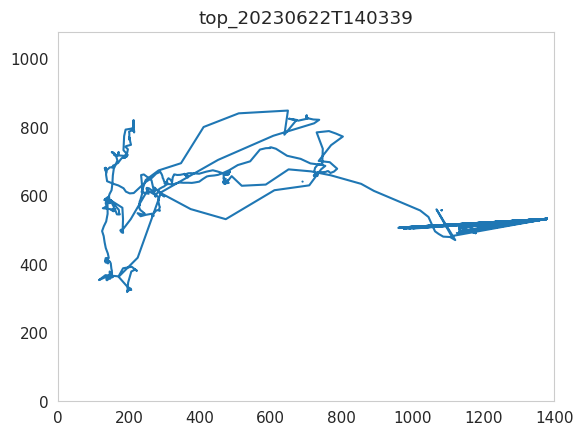

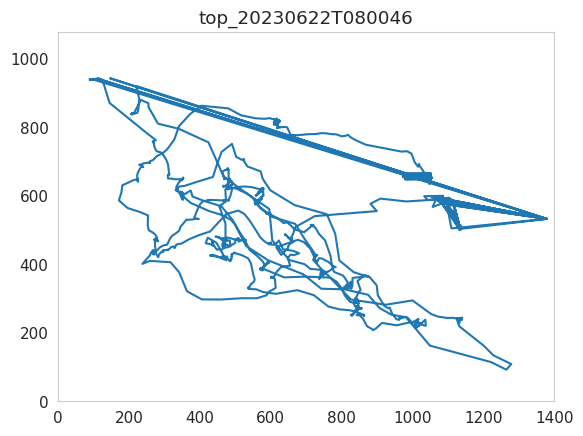

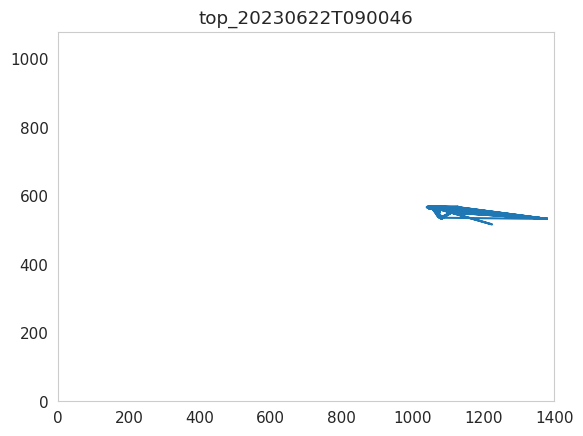

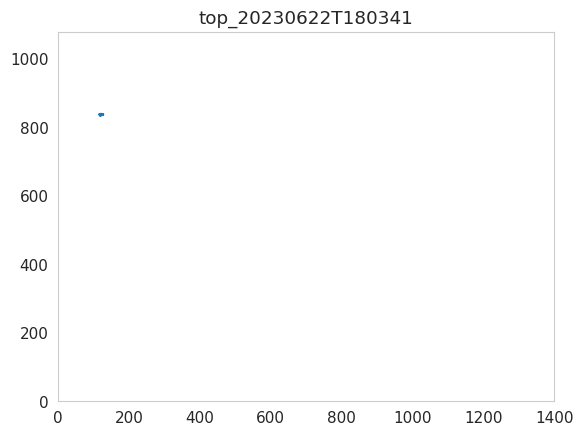

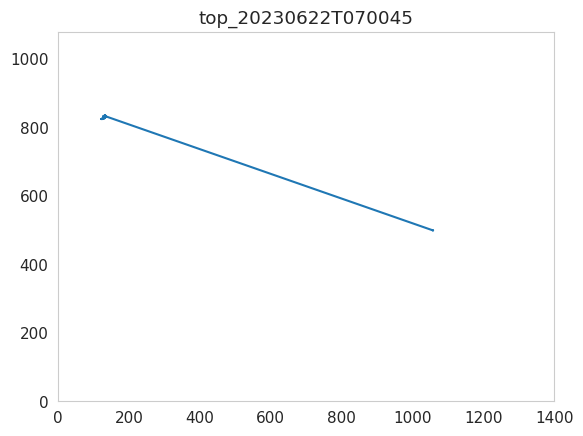

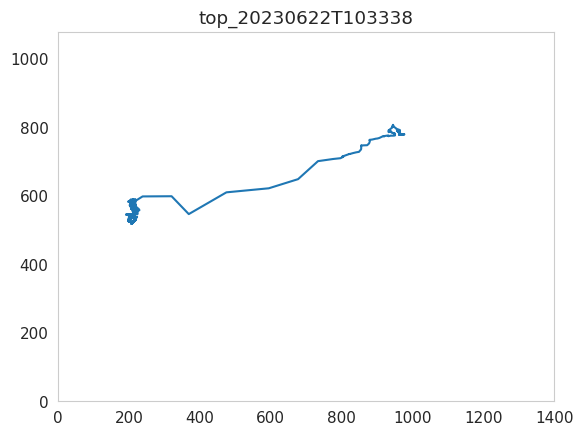

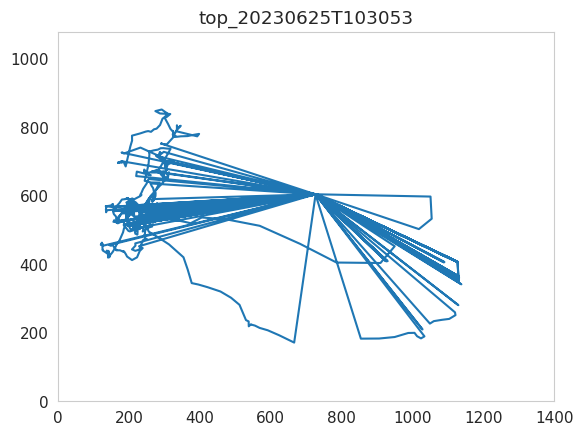

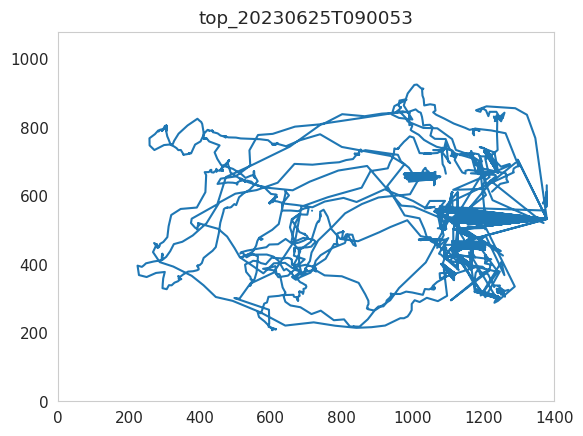

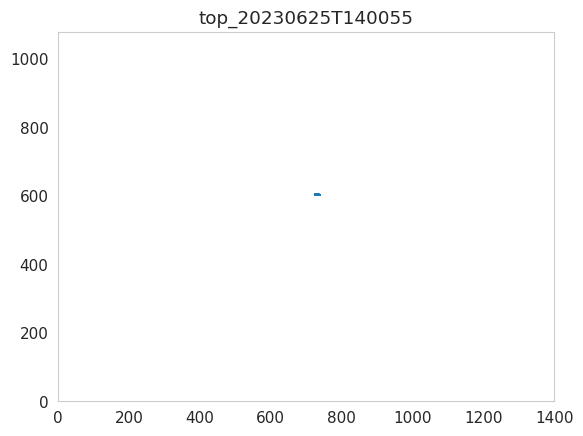

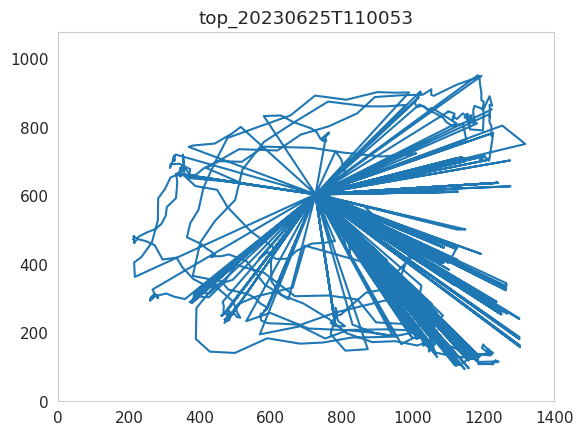

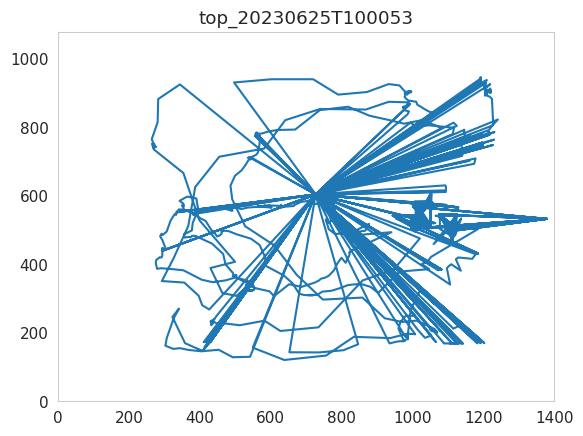

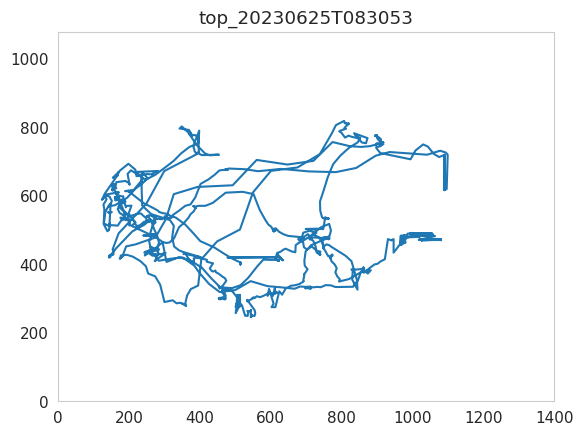

In [103]:
for name, rf in res.items():
    plt.figure()
    plt.plot(rf.cam_x*w, rf.cam_y*h)
    plt.title(name)
    plt.xlim([0, 1400])
    plt.ylim([0, 1080])

In [47]:
frames = {}
for name, video_path in {'light': '/data/Pogona_Pursuit/output/experiments/PV91/20230606/tracking/top_20230606T080107.mp4',
                         'good': '/data/Pogona_Pursuit/output/experiments/PV91/20230606/tracking/top_20230606T153805.mp4'}.items():
    cap = cv2.VideoCapture(video_path)
    ret, frames[name] = cap.read()
    cap.release()

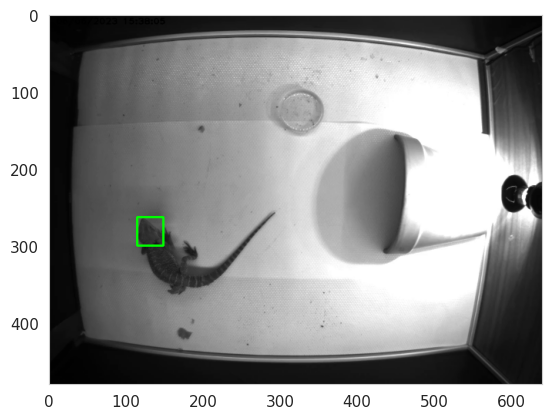

In [54]:
%matplotlib inline
from analysis.predictors.pogona_head import PogonaHead

ph = PogonaHead('top')
ph.init(None)
det, image = ph.predict(frames['good'], is_draw_pred=True)
if image is not None:
    plt.imshow(image)
    plt.show()

In [51]:
image

array([[[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 2,  2,  2],
        [ 2,  2,  2],
        [ 2,  2,  2],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       ...,

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [11, 11, 11],
        [10, 10, 10],
        [10, 10, 10]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [11, 11, 11],
        [10, 10, 10],
        [10, 10, 10]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [10, 10, 10],
        [10, 10, 10],
        [10, 10, 10]]], dtype=uint8)

/data/Pogona_Pursuit/output/experiments/PV91/20230527/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230513/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230520/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230605/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230521/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230525/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230516/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230524/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230523/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230515/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230531/tracking/predictions not exist
/data/Pogona_Pursuit/output/experiments/PV91/20230601/tracking/pr

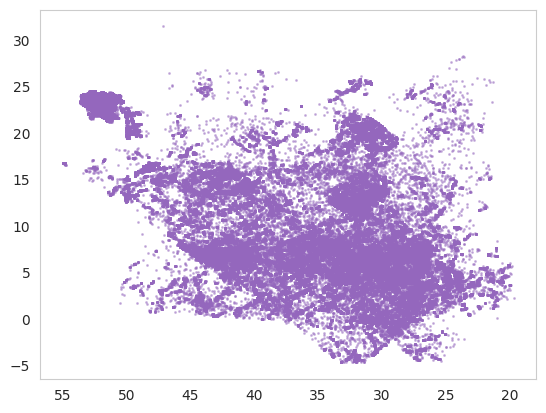

In [61]:
traj_ids = xf.groupby('video_id').y.var().sort_values(ascending=False).iloc[160:190].index.tolist()

# days = set()
# for vid_id in traj_ids:
#   xf_ = xf.query(f'video_id=={vid_id}')
#   days.add(xf_.day.iloc[0])
#   plt.scatter(xf_.x, xf_.y, s=5, alpha=0.4, c='tab:green', marker='.')

for day in days:
    xf_ = get_out_of_experiment_pose('PV91', day)
    if isinstance(xf_, pd.DataFrame):
        zf_ = xf_[['x', 'y']].apply(
            lambda pos: caliber.get_location(*pos), axis=1)
        zf_ = pd.DataFrame(zf_.tolist(), columns=('x', 'y'))
        # xf_ = xf_.query('0 <= x < 43 and y >= -2')
        plt.scatter(zf_.x, zf_.y, s=5, alpha=0.4, c='tab:purple', marker='.')

plt.gca().invert_xaxis()

In [29]:
traj_ids

[336,
 1376,
 1102,
 444,
 372,
 531,
 416,
 517,
 384,
 472,
 1262,
 1458,
 752,
 1211,
 744,
 238,
 339,
 1181,
 382,
 1198,
 318,
 332,
 1185,
 402,
 364,
 300,
 608,
 1348,
 533,
 935,
 1400,
 1071,
 267,
 501,
 1139,
 641,
 1173,
 446,
 1259,
 380]

In [ ]:
for i in range(30):
    ld = Loader(int(orm_res[i][0].id), 'front', is_load_pose=True, is_use_db=False)
    # ld.play_strike(n_frames_back=100, n_frames_forward=100)
    sa = StrikeAnalyzer(ld)
    pf = sa.pose_df
    t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
    plt.figure()
    plt.plot(t, pf['y'] - SCREEN_Y_POS['reptilearn4'])
    plt.title(i)
# z = [pf[m].values - (SCREEN_Y_POS['reptilearn4'] if m == 'y' else 0) for m in metrics.keys()]

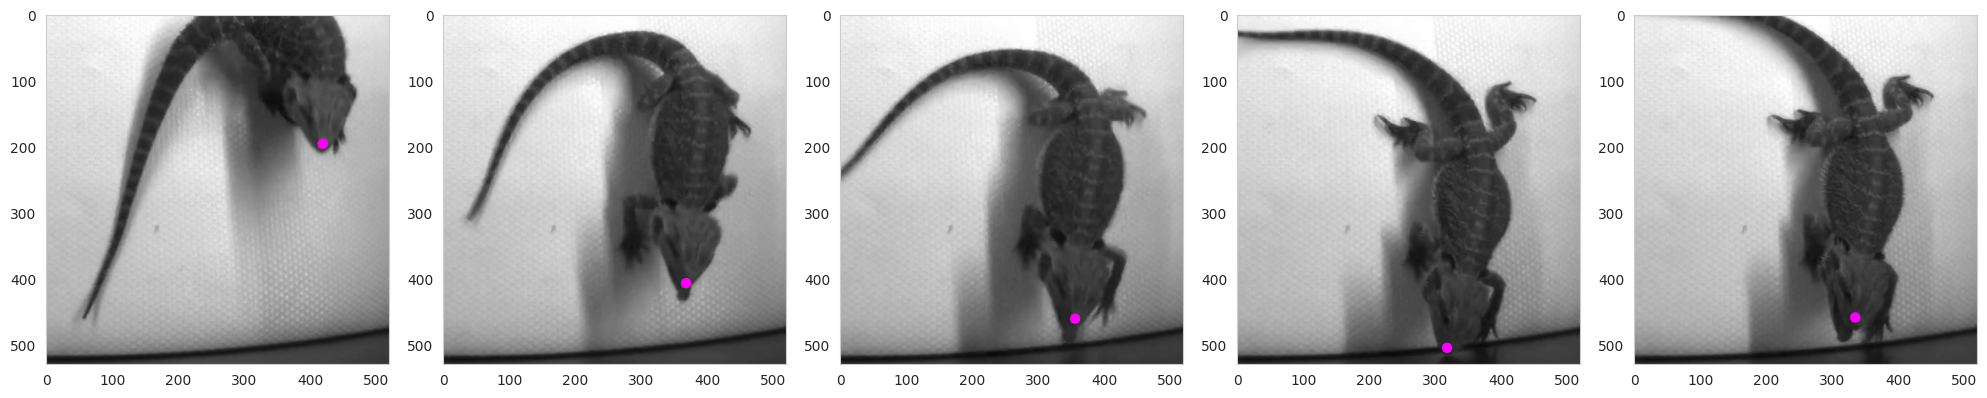

In [171]:
strike_id = 106
ld = Loader(strike_id, 'front', is_load_pose=True, is_use_db=False, sec_before=2, sec_after=2)
sa = StrikeAnalyzer(ld)
pf = sa.pose_df
t = (pf.time - pf.time.iloc[0]).dt.total_seconds()
y_values = pf['y'].values - SCREEN_Y_POS['reptilearn4']
frames = []
n_frames = len(y_values)
frames2plot = [n_frames//2-30, n_frames//2-17, n_frames//2-13, n_frames//2-5, n_frames//2+1]

fig, axes = plt.subplots(1, len(frames2plot), figsize=(20, 4))
i, j = 0, 0
for frame_id, frame in ld.gen_frames_around_strike():
    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    cX = round(pf['cam_x'][frame_id])
    cY = round(pf['cam_y'][frame_id])
    cv2.circle(frame, (cX, cY), 8, (255, 0, 255), -1)
    if i in frames2plot:
        frames.append((i, frame))
        axes[j].imshow(frame[470:1000, 730:1250])
        j += 1
    i += 1
fig.tight_layout()

In [172]:
import pickle

with open('/data/Pogona_Pursuit/notebooks/pogona_strike_frames.pkl', 'wb') as f:
    pickle.dump({'frames': frames, 'y_values': y_values}, f)

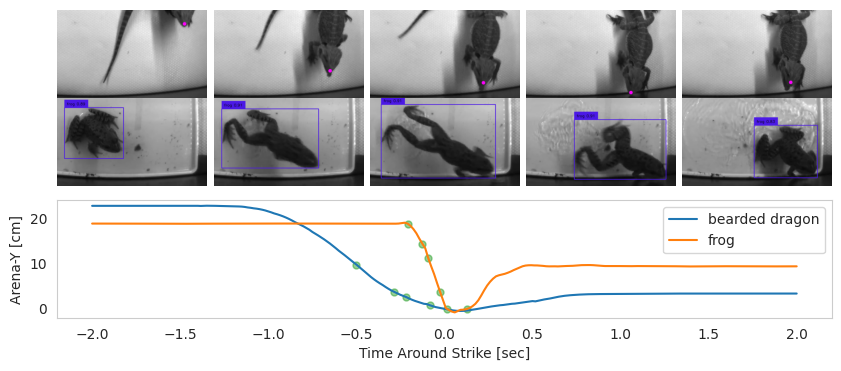

In [231]:
fig = plt.figure(figsize=(10, 4))
grid = fig.add_gridspec(ncols=1, nrows=2, height_ratios=[3, 2], hspace=0.1) 
upper_grid = grid[0, :].subgridspec(2, 5, wspace=0.04, hspace=0.001)
lower_grid = grid[1, :].subgridspec(1, 1, wspace=0.04)
upper_axes = upper_grid.subplots()
lower_axes = lower_grid.subplots()

# for i in [0, 2]:
#     middle_axes[i].axis('off')

for animal, frames_axes in [('pogona', upper_axes[0, :]), ('frog', upper_axes[1, :])]:
    with open(f'/data/Pogona_Pursuit/notebooks/{animal}_strike_frames.pkl', 'rb') as f:
        data = pickle.load(f)
    
    frames, y_values = data['frames'], data['y_values']
    t = np.linspace(-2, 2, len(y_values))
    if animal == 'frog':
        y_values = -np.array(y_values)
        y_values = savgol_filter(y_values, 7, polyorder=0)
        y_values = 20 * (y_values - y_values.min()) / (y_values.max() - y_values.min()) - 1
        y_values = y_values.tolist()
        dy = 7
        y_values = dy * [y_values[0]] + y_values[:len(y_values)-dy]
        frames = [(i+dy, frame) for i, frame in frames]
    elif animal == 'pogona':
        animal = 'bearded dragon'
    
    lower_axes.plot(t, y_values, label=animal)
    lower_axes.set_xlabel('Time Around Strike [sec]')
    lower_axes.set_ylabel('Arena-Y [cm]')
    lower_axes.scatter([t[k] for k, _ in frames], [y_values[k] for k, _ in frames], c='tab:green', s=25, alpha=0.5)
            
    for j, (_, annotated_frame) in enumerate(frames):
        frames_axes[j].imshow(annotated_frame[720:, 570:1180] if animal == 'frog' else annotated_frame[604:1000, 579:1250])
        frames_axes[j].axis('off')

lower_axes.legend()

In [23]:
with orm.session() as s:
    orm_res = s.query(Trial, Block, Experiment).join(
      Block, Block.id == Trial.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-01',
        Block.movement_type == 'jump_up'
    ).all()
    
    res = {}
    for tr, _, _ in tqdm(orm_res):
      if len(tr.strikes) < 2:
        continue
      res[tr.id] = []
      for strk in tr.strikes:
        try:
          ld = Loader(int(strk.id), 'front', sec_before=0.5, sec_after=0.5)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          # df['time'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
          res[tr.id].append((df.time.values, df.y_pose.values, df.y_traj.values))
        except Exception as exc:
          print(f'{strk.id} - {exc}')
                
res = {k: v for k, v in res.items() if v}

  0%|          | 0/1494 [00:00<?, ?it/s]

1234 - traj_df is empty
1235 - traj_df is empty
1231 - traj_df is empty
1233 - traj_df is empty
1230 - traj_df is empty
1232 - traj_df is empty
1005 - traj_df is empty
1007 - traj_df is empty
1006 - traj_df is empty
1042 - frames_df is empty after loading
1051 - traj_df is empty
1052 - traj_df is empty
1068 - traj_df is empty
1069 - traj_df is empty
1071 - traj_df is empty
1072 - traj_df is empty
1073 - traj_df is empty
1074 - traj_df is empty
1070 - traj_df is empty
2840 - Video prediction was not found for video db id: 3343
2838 - Video prediction was not found for video db id: 3343
2839 - Video prediction was not found for video db id: 3343
2836 - Video prediction was not found for video db id: 3343
2837 - Video prediction was not found for video db id: 3343
2846 - Video prediction was not found for video db id: 3347
2847 - Video prediction was not found for video db id: 3347
2848 - Video prediction was not found for video db id: 3347
2849 - Video prediction was not found for video 

In [ ]:
n = 20
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for trial_id in list(res.keys())[::-1]:
  res_ = res[trial_id]
  if i >= n:
    continue
  axes[i, 0].set_ylabel(str(trial_id))
  for r in res_:
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
  i += 1

In [24]:
with orm.session() as s:
    orm_res = s.query(Strike, Block, Experiment).join(
      Block, Block.id == Strike.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.animal_id == 'BP28'
    ).all()

In [25]:
for strk, _, _ in orm_res:
    ld = Loader(int(strk.id), 'front', is_load_pose=False, is_use_db=False)
    ld.play_strike(n_frames_back=100, n_frames_forward=100)

In [28]:
strk = orm_res[-2][0]
ld = Loader(int(strk.id), 'front', is_load_pose=False, is_use_db=False, sec_before=2, sec_after=2)
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
writer = None
for i, frame in ld.gen_frames_around_strike():
    if writer is None:
        h, w = frame.shape[:2]
        writer = cv2.VideoWriter('/data/Pogona_Pursuit/output/experiments/BP28/frog_strike1.avi', fourcc, 60, (w, h), 0)
    writer.write(frame)
    
writer.release()

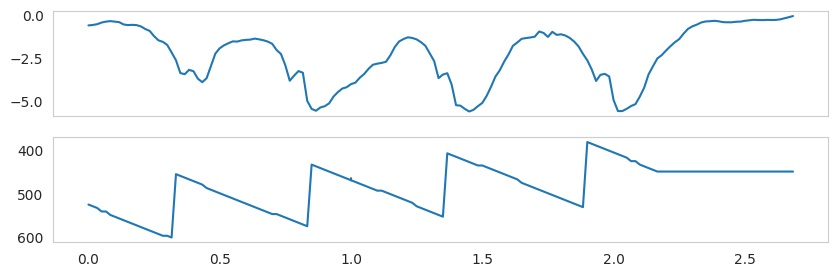

In [88]:
res_ = res[13927]
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
t = np.concatenate([r[0] for r in res_])
tidx = t.argsort()
t = t[tidx]
t = pd.Series(t - t[0]).dt.total_seconds().values
axes[0].plot(t, np.concatenate([r[1] for r in res_])[tidx])
axes[0].set_xticks([])
axes[1].plot(t, np.concatenate([r[2] for r in res_])[tidx])
axes[1].invert_yaxis()

In [ ]:
n = 50
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for r in res:
  if i >= n:
    break
  if (r[2] < 700).any():
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
    i += 1

In [148]:
trial_id = 13720
with orm.session() as s:
    orm_res = s.query(Trial, Block).join(Block, Block.id == Trial.block_id).filter(Trial.id==trial_id).first()
    traj = pd.DataFrame(orm_res[0].bug_trajectory)
    traj['time'] = pd.to_datetime(traj.time).dt.tz_localize(None)
    vid = [vid for vid in orm_res[1].videos if vid.cam_name=='front'][0]
    pose = DLCArenaPose(cam_name='front').load(video_db_id=int(vid.id))
    pose['time'] = pd.to_datetime(pose.time, unit='s')
    pose = pd.concat([pose['time'], pose['nose']], axis=1)
    
    df = pd.merge_asof(left=traj, right=pose, left_on='time', right_on='time', 
                       direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_traj', '_pose'))
    
df['time'] = (df.time - df.time.iloc[0]).dt.total_seconds()
df['y_traj'] = -(df.y_traj * (53/1440)) + 40
df['y_pose'] = df.y_pose - df.y_pose.min()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(data=df, x='time', y='y_pose', ax=ax)
sns.lineplot(data=df, x='time', y='y_traj', ax=ax)
peaks, _ = find_peaks(-df.y_pose, height=-2, distance=20, width=8)
for t_ in df.time.iloc[peaks].values:
  plt.axvline(t_, linestyle='--', c='tab:red', alpha=0.6)
ax.set_ylim([0, 20])

(0.0, 20.0)

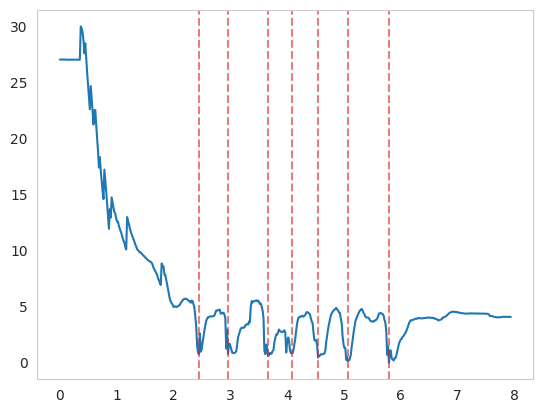

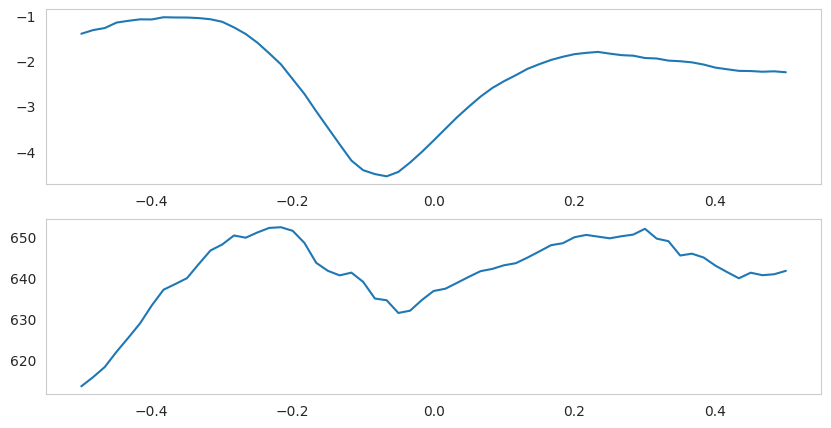

In [44]:
idx = [i for i, r in enumerate(res) if (r[2] < 700).any()]

pose_y = np.nanmean(np.vstack([x[1] for x in np.array(res)[idx]]), axis=0)
traj_y = np.nanmean(np.vstack([x[2] for x in np.array(res)[idx]]), axis=0)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(res[0][0], pose_y)
axes[1].plot(res[0][0], traj_y)

In [13]:
df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                   direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
df

time       cam_x       cam_y      prob  \
0   2023-05-31 09:36:56.289805824  881.322327  713.982605  0.999980   
1   2023-05-31 09:36:56.306471936  881.275452  713.964050  0.999980   
2   2023-05-31 09:36:56.323139072  881.338379  713.873901  0.999980   
3   2023-05-31 09:36:56.339804928  881.237244  713.778809  0.999978   
4   2023-05-31 09:36:56.356472064  881.165100  713.767151  0.999977   
..                            ...         ...         ...       ...   
236 2023-05-31 09:37:00.223077888  504.704010  904.293640  0.999876   
237 2023-05-31 09:37:00.239744000  504.537811  903.236938  0.999925   
238 2023-05-31 09:37:00.256411136  504.421417  902.344360  0.999951   
239 2023-05-31 09:37:00.273076992  504.478088  901.922485  0.999956   
240 2023-05-31 09:37:00.289742848  504.692261  901.496155  0.999956   

        x_pose    y_pose  x_traj  y_traj  
0    12.891213  5.116192    1639     755  
1    12.893800  5.117261    1639     755  
2    12.890327  5.122453    1635     755  
3    12.895909  5.127930    1631     755  
4    12.899891  5.128601    1627     755  
..         ...       ...     ...     ...  
236  21.735356 -0.189697    1267     705  
237  21.745105 -0.128837    1267     705  
238  21.751933 -0.077429    1267     705  
239  21.748608 -0.053131    1267     705  
240  21.736046 -0.028576    1267     705  

[241 rows x 8 columns]

In [20]:
df['time2'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
df

time       cam_x       cam_y      prob  \
0   2023-05-31 09:36:56.289805824  881.322327  713.982605  0.999980   
1   2023-05-31 09:36:56.306471936  881.275452  713.964050  0.999980   
2   2023-05-31 09:36:56.323139072  881.338379  713.873901  0.999980   
3   2023-05-31 09:36:56.339804928  881.237244  713.778809  0.999978   
4   2023-05-31 09:36:56.356472064  881.165100  713.767151  0.999977   
..                            ...         ...         ...       ...   
236 2023-05-31 09:37:00.223077888  504.704010  904.293640  0.999876   
237 2023-05-31 09:37:00.239744000  504.537811  903.236938  0.999925   
238 2023-05-31 09:37:00.256411136  504.421417  902.344360  0.999951   
239 2023-05-31 09:37:00.273076992  504.478088  901.922485  0.999956   
240 2023-05-31 09:37:00.289742848  504.692261  901.496155  0.999956   

        x_pose    y_pose  x_traj  y_traj     time2  
0    12.891213  5.116192    1639     755 -1.999968  
1    12.893800  5.117261    1639     755 -1.983302  
2    12.890327  5.122453    1635     755 -1.966635  
3    12.895909  5.127930    1631     755 -1.949969  
4    12.899891  5.128601    1627     755 -1.933302  
..         ...       ...     ...     ...       ...  
236  21.735356 -0.189697    1267     705  1.933304  
237  21.745105 -0.128837    1267     705  1.949970  
238  21.751933 -0.077429    1267     705  1.966637  
239  21.748608 -0.053131    1267     705  1.983303  
240  21.736046 -0.028576    1267     705  1.999969  

[241 rows x 9 columns]

<AxesSubplot:xlabel='time', ylabel='y_traj'>

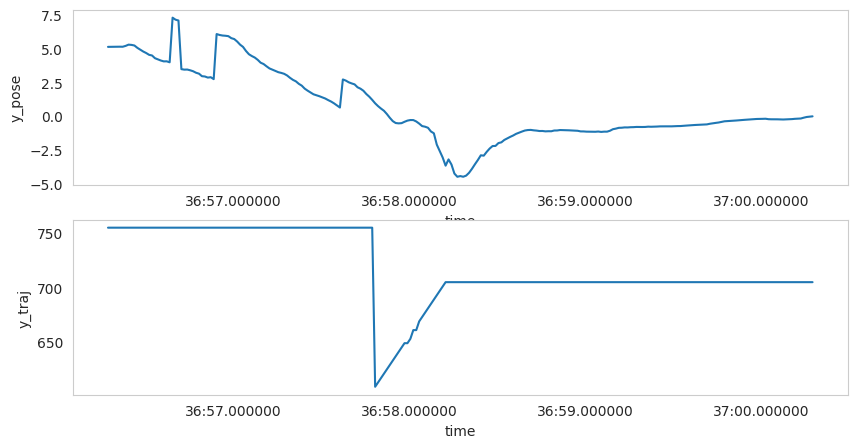

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=df, x='time', y='y_pose', ax=axes[0])
sns.lineplot(data=df, x='time', y='y_traj', ax=axes[1])